In [2]:
# Settings for Analysis

# settings for exlusion
minimum_dim = 500

# settings for contour plots
c_cmap = 'brg' # colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6, 0.3, 0.1]) # energy percentages to contour
interp_val = 5

# settings for calcuations
alpha_a_fitrange = [0.02, 0.35] 

Total Images Before Size Filter: {} 214
number of aca images: 136
min aca image height: 504
min aca image width: 640
number of naca images: 72
min naca image height: 601
min naca image width: 719
Total Images After Size Filter: 208


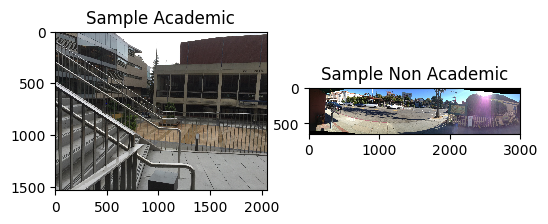

In [3]:
# Read our photo files
aca_datadir = './data/**/*Pano*/*AP*/**'
naca_datadir = './data/**/*Pano*/*NA*/**'
both_datadir = './data/**/'

aca_image_files = readin.readin_jpgs(aca_datadir)
naca_image_files = readin.readin_jpgs(naca_datadir)
image_files = aca_image_files + naca_image_files
print('Total Images Before Size Filter: {}' ,len(image_files))

try:
    raw_images
except NameError:
#if(1):
    raw_images, raw_flist, min_h, min_w = readin.read_ims(image_files, minimum_dim)
    aca_raw_images, aca_raw_flist, aca_min_h, aca_min_w = readin.read_ims(aca_image_files, minimum_dim)
    naca_raw_images, naca_raw_flist, naca_min_h, naca_min_w = readin.read_ims(naca_image_files, minimum_dim)
    #use less of height and width to make samples square
    min_dim = min(aca_min_h, aca_min_w, naca_min_h, naca_min_w)
    
plt.subplot(1, 2, 1, title="Sample Academic")
plt.imshow(aca_raw_images[0])

print('number of aca images: {}'.format(np.shape(aca_raw_images)[0]))
print('min aca image height: {}'.format(aca_min_h))
print('min aca image width: {}'.format(aca_min_w))

plt.subplot(1, 2, 2, title="Sample Non Academic")
plt.imshow(naca_raw_images[0])

print('number of naca images: {}'.format(np.shape(naca_raw_images)[0]))
print('min naca image height: {}'.format(naca_min_h))
print('min naca image width: {}'.format(naca_min_w))

print('Total Images After Size Filter:' ,len(aca_raw_images) + len(naca_raw_images))

In [4]:
# read in axial lengths
aca_xls = './data/Non Academic Period Master Spreadsheet 8.13.15 .xlsx'
nonaca_xls = './data/Academic Period Master Spreadsheet 8.13.15 .xlsx'

aca_als = readin.readin_al_xls(aca_xls)
aca_als.columns = ['ACA OD AL','ACA OS AL']
naca_als = readin.readin_al_xls(nonaca_xls)
naca_als.columns = ['NACA OD AL','NACA OS AL']

# combine to one spreadsheet
als = pd.concat([aca_als,naca_als],axis=1)
al_subjects = als.index

#get a subject list that only contains those with images we will analyze BADASS double list comprehension
subjects = np.unique([sub for sub in list(al_subjects) for file in raw_flist if sub in file])

# Print table
print(als) 

          ACA OD AL ACA OS AL NACA OD AL NACA OS AL
AG102816        NaN       NaN      24.18      24.29
AH110515      23.06     23.09      23.16      23.17
AL100115        NaN       NaN       25.6      25.14
AN120915      25.16     25.46      25.15       25.5
CB030217        NaN       NaN      23.31      23.17
CH121015         25     25.41        NaN        NaN
CL021617        NaN       NaN      24.72      24.94
CM021816        NaN       NaN      25.07      25.08
DC080615      24.21     24.15        NaN        NaN
DG110915        NaN       NaN      23.98      23.69
DH030317        NaN       NaN      23.16      23.47
GG073115      23.75     23.87        NaN        NaN
GJ041316        NaN       NaN      24.19      24.19
HL110215      25.11     24.85      25.05      24.88
HM110316        NaN       NaN      21.83      21.77
IK030117        NaN       NaN      24.75      24.67
JC101615      22.96      23.1      22.86      23.03
JC102715      26.26     26.42      26.22      26.35
JC110615    

In [264]:
def cropims(ims, crop_h, crop_w, area, lr_replicates=False):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    # newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        # print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h / 2) # half image height
        h_im_w = np.int(im_w / 2) # half image width
        
        #check to see if we have large enough images to crop
        if(im_w < 2*crop_w):
            lr_replicates=False
        
        if(area=='middle'):
            newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                       h_im_w - h_crop_w:h_im_w + h_crop_w+1, # crop width
                       :]  
            if(np.shape(newim)[0]==0):
                print(h_im_h)
                print(h_crop_h)
                print(np.shape(im))
            #print('mid{}'.format(np.shape(newim)))
            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]

                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_mid{}'.format(np.shape(l_newim)))
                #print('right_mid{}'.format(np.shape(r_newim)))


        elif(area=='top'):
            newim = im[0:crop_h, # crop height
                       h_im_w - h_crop_w-1:h_im_w + h_crop_w, # crop width
                       :]
            #print('top{}'.format(np.shape(newim)))

            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[0:crop_h, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[0:crop_h, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]
                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_top{}'.format(np.shape(l_newim)))
                #print('right_top{}'.format(np.shape(r_newim)))

            
        elif(area=='bottom'):
            newim = im[im_h - crop_h:im_h, # crop height
                       h_im_w - h_crop_w-1:h_im_w + h_crop_w, # crop width
                       :]
            #print('but{}'.format(np.shape(newim)))

            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[im_h - crop_h:im_h, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[im_h - crop_h:im_h, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]
                
                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_but{}'.format(np.shape(l_newim)))
                #print('right_but{}'.format(np.shape(r_newim)))

        else:
            raise ValueError('area not well specified!')
        
    return(newims)

def resizeims(ims, edgesize):
    #funtion to resize image to smallest of all images.
    #function first crops to smaller dimension (height or width) then resizes to edgesize.
    newims = []
    for i, im in enumerate(ims):

        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        
        crop = min(im_h, im_w) #size to crop both dims to
        h_crop = np.int(crop/2)

        h_im_h = np.int(im_h / 2) # half image height
        h_im_w = np.int(im_w / 2) # half image width
        
        
        #crop middle of image to give us a square image
        cropped = im[h_im_h-h_crop:h_im_h+h_crop,
                     h_im_w-h_crop:h_im_w+h_crop]
        
        #resize image to given edgesize. Image is already square
        resized = scipy.misc.imresize(cropped, (edgesize,edgesize))
        #resized = cropped.resize(edgesize,edgesize, Image.ANTIALIAS)
        
        newims.append(resized)
    return(newims)

def avgims(ims):
    ims_arr = np.array(ims)
    # average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    # print(np.shape(avg))
    for c in range(np.shape(avg)[2]): # loop over R, G, and B
        avg[:, :, c] = np.mean(ims_arr[:, :, :, c], axis=0)
    return(avg)

def spatialft(image):
    """Take the fourier transform of the image.
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""
    
    greyavgim = np.mean(np.asarray(image),axis=2)  # average over colors
    greyavgim =  greyavgim - np.mean(greyavgim)  # remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))]
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

def get_logspace_contours(raw_field, c_levels=c_levels):
    """Get the contour locations by percentage"""
    log_field = np.log10(raw_field)
    field = log_field / log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    
    t_contours = f(c_levels) * log_field.sum()
    linear_t_contours = 10**t_contours
    
    return(linear_t_contours)

def fit_alpha_as(set_ims, direction):
    
    set_avgim = avgims(set_ims)
    
    # 1/f function to fit
    def feq(cpd, a, alpha):
        amp = a / (cpd**alpha)
        return(amp)
    
    # data to fit function to
    minfit = alpha_a_fitrange[0]
    maxfit = alpha_a_fitrange[1]
    
    # initialize values
    xs = []
    ys = []
    
    # cacluate ft and fit values for each image, so we have many points to fit
    for i, im in enumerate(set_ims):
        # normalize our image
        normim = im / np.max(set_avgim)
        
        # calculate the fourier transform
        im_bw, ft2d, ps2d, fqs = spatialft(normim)
        
        if(direction == 'vertical'):
            # which VERTICAL frequency is closest to the min we want (index)?
            minfq = np.abs(fqs[1] - minfit).argmin()
            # which VERTICAL frequency is closest to the max we want (index)?
            maxfq = np.abs(fqs[1] - maxfit).argmin()
            # add our values for VERTICAL frequencies between these limits
            xs.append(fqs[1][minfq:maxfq])
            # add our values for VERTICAL fourier amps in this limit
            ys.append(ft2d[int(np.shape(ft2d)[0]/2),minfq:maxfq])

        elif(direction == 'horizontal'):
            # index of horiz frequency closest to range
            minfq = np.abs(fqs[0] - minfit).argmin()
            # index of horiz frequency closest to range
            maxfq = np.abs(fqs[0] - maxfit).argmin()
            # horiz fqs in these limits
            xs.append(fqs[0][minfq:maxfq])
            # hoirz fourier amps in range
            ys.append(ft2d[minfq:maxfq, int(np.shape(ft2d)[1] / 2)])
            
        elif(direction == 'skew'):
            # use x index here [0] to ensure same size
            skewfqs = np.sqrt(np.add(fqs[0][-int(np.shape(ft2d)[0]/2):]**2,
                                     fqs[1][-int(np.shape(ft2d)[0]/2):]**2))
            # skew frequncies diagonally out from middle by pythagorean therom ASSUME EQUALLY SPACED
            # index of skew fq closest to range
            minfq = np.abs(skewfqs - minfit).argmin()
            # index of skew fq closest to range
            maxfq = np.abs(skewfqs - maxfit).argmin()

            for angle in [45,135]:
                xs.append(skewfqs[minfq:maxfq])
                if(45):
                    # start from middle to measure y fqs
                    ys.append(np.diagonal(ft2d[int(np.shape(ft2d)[0]/2) + minfq:int(np.shape(ft2d)[0]/2) + maxfq,
                                               int(np.shape(ft2d)[1]/2) + minfq:int(np.shape(ft2d)[1]/2) + maxfq]))
                else:
                    ft2d_flip = np.fliplr(ft2d) #flip indexes to get the 135 degree angle
                    ys.append(np.diagonal(ft2d_flip[int(np.shape(ft2d_flip)[0]/2) + minfq:int(np.shape(ft2d_flip)[0]/2) + maxfq,
                                               int(np.shape(ft2d_flip)[1]/2) + minfq:int(np.shape(ft2d_flip)[1]/2) + maxfq]))       
        else:
            raise NameError('no recognized direction specified to fit a and alpha!')
        
        # fit
        [a, alpha], cov = scipy.optimize.curve_fit(feq,
                                                  np.array(xs).flatten(),
                                                  np.array(ys).flatten())
        # convert to 1SD
        [a_se, alpha_se] = np.sqrt(np.diag(cov))

    return(a, a_se, alpha, alpha_se)


def interp_get_contours(ps):
    interp = scipy.ndimage.filters.gaussian_filter(ps, interp_val)
    contours = get_logspace_contours(interp)
    return(interp, contours)

def contour_plotter(ps, fqs, bar=True, ticks=True):
    """Function to make contour plots"""
    interp, contours = interp_get_contours(ps)
    cont_pl = plt.pcolormesh(fqs[1],
                             fqs[0],
                             interp,
                             cmap="gray",
                             norm=mpl.colors.LogNorm())#,extent=extents)
    
    if(bar):
        cont_pl = plt.colorbar()
        
    if not(ticks):
        plt.axis('off')
    
    pl = plt.contour(fqs[1],
                     fqs[0],
                     interp,
                     levels=contours,
                     cmap=c_cmap,
                     norm=mpl.colors.LogNorm())
    return(pl)


def implot(im):
    pl = plt.imshow(im)
    pl = plt.axis('off')

def rgb_ims(ims):
    rgbs = []
    for im in ims:
        #print(im.shape)
        immean = np.mean(im,axis=2)
        #print(immean.shape)
        r = np.mean(((im[:,:,0]+0.01)/(immean+0.01)).flatten())
        g = np.mean(((im[:,:,1]+0.01)/(immean+0.01)).flatten())
        b = np.mean(((im[:,:,2]+0.01)/(immean+0.01)).flatten())
        rgbs.append([r,g,b])
    return(rgbs)

def analyze_imset(set_ims, min_dim, dictloc, crop):

    #rgb values (calculate on raws before averaging or cropping)
    dictloc['rgb'] = rgb_ims(set_ims)
    
    #resized image
    resized = resizeims(ims=set_ims, edgesize=min_dim)
    dictloc['images'] = resized

    # calculate average image
    dictloc['avgim'] = avgims(dictloc['images'])
    # calcuate FT & PS
    fft_results = spatialft(dictloc['avgim'])
    dictloc['avgim_bw'] = fft_results[0]
    dictloc['avgim_fft'] = fft_results[1]
    dictloc['avgim_ps'] = fft_results[2]
    dictloc['avgim_fft_freqs'] = fft_results[3]

    # fit alpha & as for each dicretion
    for direction in ['horizontal', 'vertical','skew']:
        alpha_fits_h = fit_alpha_as(dictloc['images'],direction)
        dictloc['avgim_a_{}'.format(direction)] = alpha_fits_h[0]
        dictloc['avgim_a_se_{}'.format(direction)] = alpha_fits_h[1]
        dictloc['avgim_alpha_{}'.format(direction)] = alpha_fits_h[2]
        dictloc['avgim_alpha_se_{}'.format(direction)] = alpha_fits_h[3]
    
    #if we want to also use cropped images    
    if(crop):
        dictloc['cropped'] = {}
        for loc in ['top', 'middle', 'bottom']:
            dictloc['cropped'][loc] = {}

            # calculate cropped version of images
            cropped = cropims(ims=set_ims,
                              crop_h=min_dim,
                              crop_w=min_dim,
                              area=loc,
                              lr_replicates = True)
            #for c in cropped:
            #    print(np.shape(c))
            dictloc['cropped'][loc]['images'] = cropped

            # calculate average image
            dictloc['cropped'][loc]['avgim'] = avgims(dictloc['cropped'][loc]['images'])
            # calcuate FT & PS
            fft_results = spatialft(dictloc['cropped'][loc]['avgim'])
            dictloc['cropped'][loc]['avgim_bw'] = fft_results[0]
            dictloc['cropped'][loc]['avgim_fft'] = fft_results[1]
            dictloc['cropped'][loc]['avgim_ps'] = fft_results[2]
            dictloc['cropped'][loc]['avgim_fft_freqs'] = fft_results[3]

            # fit alpha & as for each dicretion
            for direction in ['horizontal', 'vertical','skew']:
                alpha_fits_h = fit_alpha_as(dictloc['cropped'][loc]['images'],direction)
                dictloc['cropped'][loc]['avgim_a_{}'.format(direction)] = alpha_fits_h[0]
                dictloc['cropped'][loc]['avgim_a_se_{}'.format(direction)] = alpha_fits_h[1]
                dictloc['cropped'][loc]['avgim_alpha_{}'.format(direction)] = alpha_fits_h[2]
                dictloc['cropped'][loc]['avgim_alpha_se_{}'.format(direction)] = alpha_fits_h[3]

    return(dictloc)

In [265]:
# make a dictionary to organize our data better
ddict = {}

# summarize academic and non academic for ALL subjects
ddict['aca'] = {}
ddict['naca'] = {}
# add raw images to our dictionary
ddict['aca']['images_raw'] = aca_raw_images
ddict['naca']['images_raw'] = naca_raw_images
# analyze overall NACA and ACA
ddict['aca'] = analyze_imset(set_ims = aca_raw_images,
                             min_dim = min_dim,
                             dictloc = ddict['aca'],
                             crop = False)
ddict['naca'] = analyze_imset(set_ims = naca_raw_images,
                              min_dim = min_dim,
                              dictloc = ddict['naca'],
                              crop = False)

# analyze images for each individual subject
for i, sub in enumerate(subjects):
    
    # get lists of subject's images - must leave as list because they are different sizes
    aca_sub_idxs = [i for i, x in enumerate(aca_raw_flist) if sub in x]
    naca_sub_idxs = [i for i, x in enumerate(naca_raw_flist) if sub in x]
    aca_subims = [aca_raw_images[i] for i in aca_sub_idxs]
    naca_subims = [naca_raw_images[i] for i in naca_sub_idxs]
    sub_idxs = [i for i, x in enumerate(raw_flist) if sub in x]
    subims = [raw_images[i] for i in sub_idxs]
    
    # make a sub dictionary 
    ddict[sub] = {}
      
    # put AL values into dict
    ddict[sub]['AL'] = als.loc[sub]
    
    # analyze subject's overall images
    thisloc = ddict[sub]

    # if there are images in this category then calculate averages and ft for them
    if not np.shape(subims) == (0, ):
        ddict[sub] = analyze_imset(set_ims = subims,
                                min_dim = min_dim,
                                dictloc = thisloc,
                                crop = False)

    # analyze academic & nonacademic separately
    if not np.shape(aca_subims) == (0, ):
        school = 'aca'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = aca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc,
                                        crop = False)
    if not np.shape(naca_subims) == (0, ):
        school = 'naca'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = naca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc,
                                        crop = False)
        

In [266]:
print(ddict['aca'].keys())

dict_keys(['images_raw', 'rgb', 'images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew'])


In [ ]:
#plot a few example images

sample_sub = 'HL110215'

print(ddict[sample_sub]['aca'].keys())

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1, title="Average Academic")
implot(ddict[sample_sub]['aca']['avgim'])


plt.subplot(2, 2, 2, title="Average Non Academic")
implot(ddict[sample_sub]['naca']['avgim'])

plt.subplot(2, 2, 3, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['aca']['avgim_ps'],
                fqs = ddict[sample_sub]['aca']['avgim_fft_freqs'],
                bar=True)

plt.subplot(2, 2, 4, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['naca']['avgim_ps'],
                fqs = ddict[sample_sub]['naca']['avgim_fft_freqs'],
                bar=True)

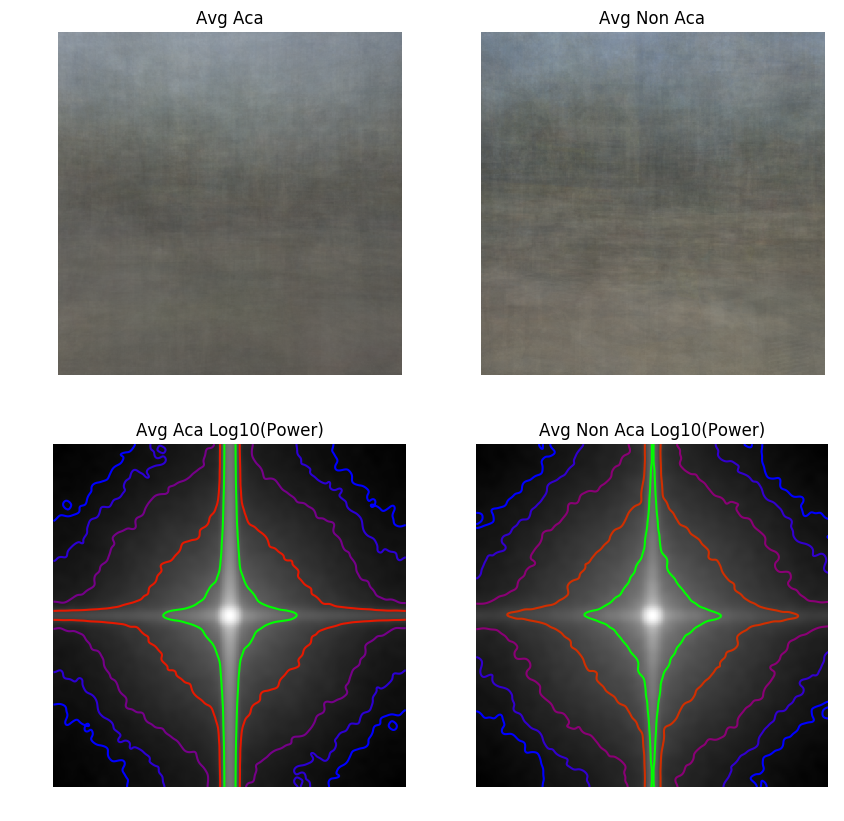

In [129]:
#plot the average images comparing academic and non-academic

plt.figure(figsize=(10,10))

ax = plt.subplot(2, 2, 1, title="Avg Aca")
implot(ddict['aca']['avgim'])

ax = plt.subplot(2, 2, 2, title="Avg Non Aca")
implot(ddict['naca']['avgim'])

ax = plt.subplot(2, 2, 3, title='Avg Aca Log10(Power)')
contour_plotter(ps = ddict['aca']['avgim_ps'],
                fqs = ddict['aca']['avgim_fft_freqs'], bar=False, ticks=False)
    
ax = plt.subplot(2, 2, 4, title='Avg Non Aca Log10(Power)')
contour_plotter(ps = ddict['naca']['avgim_ps'],
                fqs = ddict['naca']['avgim_fft_freqs'], bar=False, ticks=False)

In [10]:
#make a pandas df to hold our data

fits_df = pd.DataFrame(columns = ('variable','direction','academic','value'))
i=0
for variable in ['a','a_se','alpha','alpha_se']:
    for direction in ['vertical','horizontal','skew']:
        for academic in ['aca','naca']:
            value = ddict[academic]['avgim_{}_{}'.format(variable,direction)]
            fits_df.loc[i] = ([variable,direction,academic,value])
            i+=1
#a_alpha_fits_df

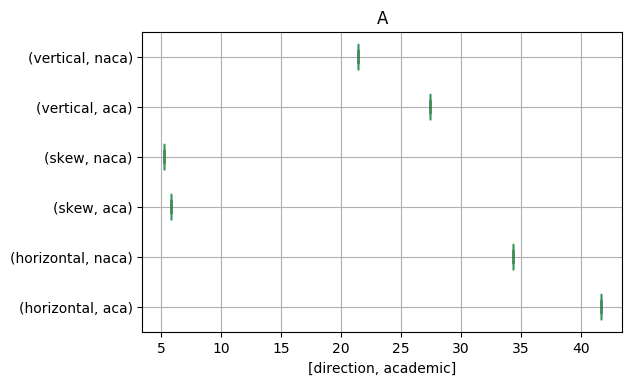

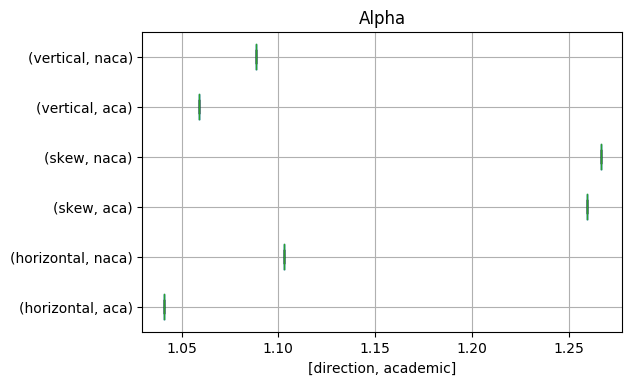

In [11]:
a = fits_df[(fits_df.variable == 'a')]
alpha = fits_df[(fits_df.variable == 'alpha')]

plt.figure(figsize=(10,20))
a.boxplot(by=['direction','academic'],vert=False)
plt.title('A')
plt.suptitle('')

alpha.boxplot(by=['direction','academic'],vert=False)
plt.title('Alpha')
plt.suptitle('')

In [12]:
a = fits_df[fits_df.variable == 'a'].set_index(['academic','direction'])
a_se = fits_df[fits_df.variable == 'a_se'].set_index(['academic','direction'])

alpha = fits_df[fits_df.variable == 'alpha'].set_index(['academic','direction'])
alpha_se = fits_df[fits_df.variable == 'alpha_se'].set_index(['academic','direction'])

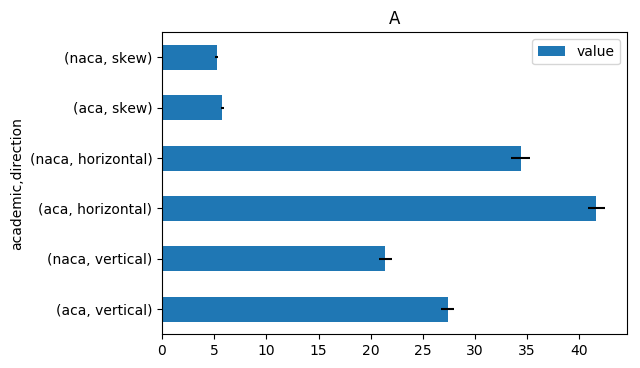

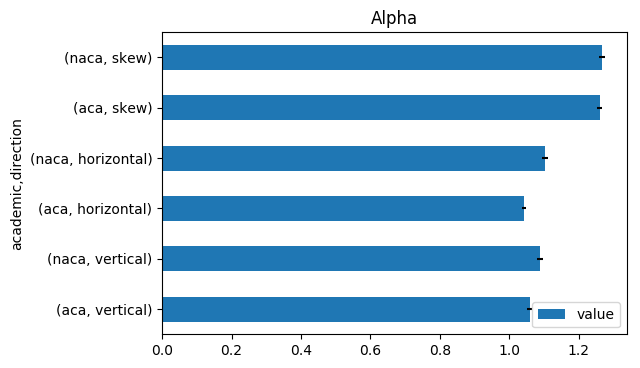

In [13]:
a.plot(xerr = a_se,title='A',kind='barh')
alpha.plot(xerr = alpha_se,title='Alpha',kind='barh')

In [14]:
ddict['aca'].keys()

dict_keys(['images_raw', 'images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew'])

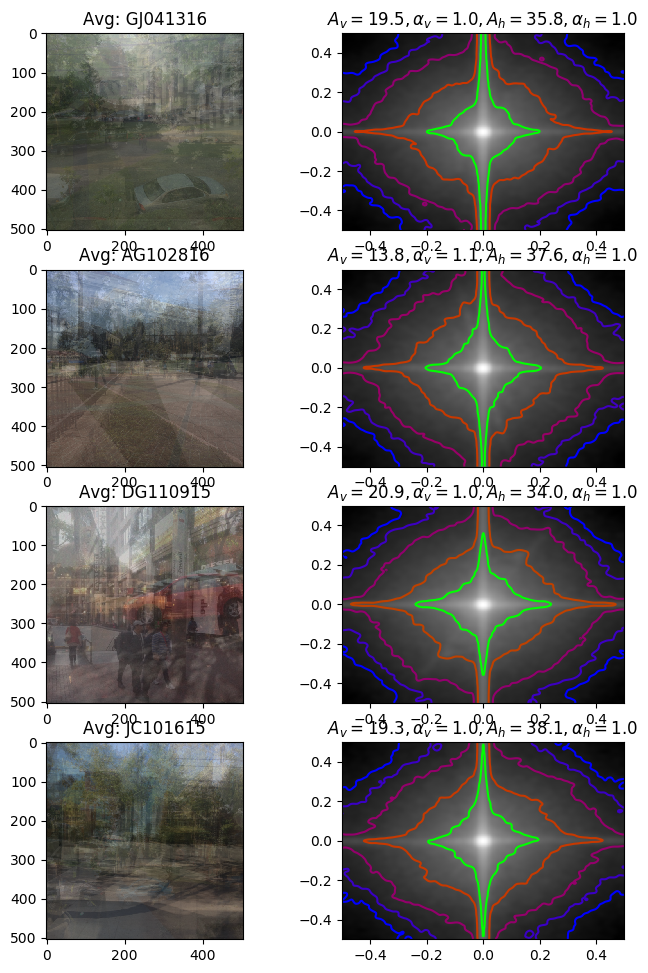

In [15]:
#plot 2d power spectra for n random subjects

n=4
trs = np.random.choice(subjects,n,replace=False)

plt.subplots(nrows=2,ncols=n,figsize =(8,n*3))

for i in range(n):

    sub = trs[i]
    plt.subplot(n,2,2*i+1, title='Avg: {}'.format(sub))
    plt.imshow(ddict[sub]['avgim'], interpolation='none',cmap='gray')
    plt.subplot(n,2,2*i+2,
                title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(ddict[sub]['avgim_a_vertical'],
                                                                                            ddict[sub]['avgim_alpha_vertical'],
                                                                                            ddict[sub]['avgim_a_horizontal'], 
                                                                                            ddict[sub]['avgim_alpha_horizontal'])
                )

    contour_plotter(ddict[sub]['avgim_ps'],
                    fqs = ddict[sub]['avgim_fft_freqs'],
                    bar=False)
                    

In [16]:
subjects

array(['AG102816', 'AH110515', 'AN120915', 'CH121015', 'CM021816',
       'DC080615', 'DG110915', 'GG073115', 'GJ041316', 'HL110215',
       'HM110316', 'JC101615', 'JC102715', 'JC110615', 'JF041316',
       'JH091715', 'JN110915', 'LS073115', 'LW072415', 'MC110416',
       'MD072415', 'MH020416', 'ML033116', 'ML072115', 'MN120815',
       'NS091015', 'PS102015', 'SB101416', 'SG021116', 'SZ091115',
       'TE072715', 'VP041416', 'WO021616'], 
      dtype='<U8')

In [17]:
# compare A and Alpha with Axial Length

al_fits = pd.DataFrame(columns = ('subject','direction','a','a_se','alpha','alpha_se','AL_OD','AL_OS'))
    
i=0
for sub in subjects:
    for direction in ['vertical','horizontal','skew']:
        a = ddict[sub]['avgim_a_{}'.format(direction)]
        a_se = ddict[sub]['avgim_a_se_{}'.format(direction)]
        alpha = ddict[sub]['avgim_alpha_{}'.format(direction)]
        alpha_se = ddict[sub]['avgim_alpha_se_{}'.format(direction)]
        al_od = np.mean(als.loc[sub][['NACA OD AL','ACA OD AL']])
        al_os = np.mean(als.loc[sub][['NACA OS AL','ACA OS AL']])
        al_fits.loc[i] = ([sub, direction, a, a_se, alpha, alpha_se, al_od, al_os])
        i+=1

In [18]:
al_fits

subject   direction          a      a_se     alpha  alpha_se   AL_OD  \
0   AG102816    vertical  13.787791  1.122317  1.132963  0.024553  24.180   
1   AG102816  horizontal  37.634416  2.274476  0.986141  0.018878  24.180   
2   AG102816        skew   5.820346  0.509168  1.143168  0.026107  24.180   
3   AH110515    vertical  23.967314  2.037760  1.043593  0.026175  23.110   
4   AH110515  horizontal  26.612374  1.780659  1.111156  0.020276  23.110   
5   AH110515        skew   2.979202  0.276987  1.363166  0.026725  23.110   
6   AN120915    vertical  10.334373  0.894807  1.172040  0.025913  25.155   
7   AN120915  horizontal  30.665938  2.408259  1.044056  0.024170  25.155   
8   AN120915        skew   4.673735  0.340361  1.154688  0.021679  25.155   
9   CH121015    vertical   8.976612  1.262452  1.084534  0.042873  25.000   
10  CH121015  horizontal  29.535540  3.679582  1.127342  0.037623  25.000   
11  CH121015        skew   3.565814  0.306561  1.220607  0.025271  25.000   
12  CM021816    vertical  28.656052  2.243718  1.104956  0.023760  25.070   
13  CM021816  horizontal  24.857238  2.047739  1.066366  0.025219  25.070   
14  CM021816        skew   8.836562  0.547015  1.120640  0.018562  25.070   
15  DC080615    vertical  13.354502  1.918235  1.021055  0.044454  24.210   
16  DC080615  horizontal  34.010051  3.402247  1.056813  0.030693  24.210   
17  DC080615        skew   1.934407  0.216851  1.415022  0.031997  24.210   
18  DG110915    vertical  20.908247  4.177229  1.045716  0.061464  23.980   
19  DG110915  horizontal  33.978893  3.100864  0.965508  0.028668  23.980   
20  DG110915        skew   3.826606  0.559635  1.270516  0.042635  23.980   
21  GG073115    vertical   6.938877  0.802530  1.208645  0.034370  23.750   
22  GG073115  horizontal  29.897857  2.892867  1.113452  0.029309  23.750   
23  GG073115        skew   3.733888  0.509274  1.293914  0.039618  23.750   
24  GJ041316    vertical  19.496261  1.856671  0.990453  0.029719  24.190   
25  GJ041316  horizontal  35.843717  2.096027  0.987921  0.018258  24.190   
26  GJ041316        skew   4.155449  0.377454  1.206313  0.026773  24.190   
27  HL110215    vertical  23.773374  1.988672  1.086177  0.025488  25.080   
28  HL110215  horizontal  32.557531  3.093953  1.157046  0.028524  25.080   
29  HL110215        skew   7.392558  0.610863  1.175339  0.024500  25.080   
..       ...         ...        ...       ...       ...       ...     ...   
69  ML072115    vertical  19.214207  1.594270  0.991993  0.025878  24.345   
70  ML072115  horizontal  46.790668  4.175543  0.958391  0.028087  24.345   
71  ML072115        skew   1.985553  0.199366  1.470662  0.028457  24.345   
72  MN120815    vertical  14.499464  1.276970  1.107135  0.026710  22.290   
73  MN120815  horizontal  35.665620  3.418270  1.031596  0.029587  22.290   
74  MN120815        skew   3.848976  0.456915  1.335319  0.034270  22.290   
75  NS091015    vertical  29.021451  3.880493  1.037376  0.041220  24.760   
76  NS091015  horizontal  25.682118  3.885884  1.017672  0.046863  24.760   
77  NS091015        skew   4.127407  0.494250  1.195734  0.035365  24.760   
78  PS102015    vertical  22.975821  1.844537  1.049825  0.024673  23.905   
79  PS102015  horizontal  19.550926  1.786023  1.180859  0.027292  23.905   
80  PS102015        skew   4.962461  0.373816  1.240757  0.022071  23.905   
81  SB101416    vertical  14.583401  1.589018  1.104722  0.033064  23.950   
82  SB101416  horizontal  30.894897  2.337494  1.077811  0.023101  23.950   
83  SB101416        skew   3.251355  0.452650  1.311741  0.040317  23.950   
84  SG021116    vertical  21.954649  2.035145  1.029125  0.028629  24.500   
85  SG021116  horizontal  40.699410  2.804158  1.003165  0.021428  24.500   
86  SG021116        skew   3.306199  0.299472  1.369272  0.026016  24.500   
87  SZ091115    vertical  23.776125  2.242352  0.981475  0.029498  24.595   
88  SZ091115  horizontal  29.303684  2.187211  1.145609  0.022452  24.595   
8

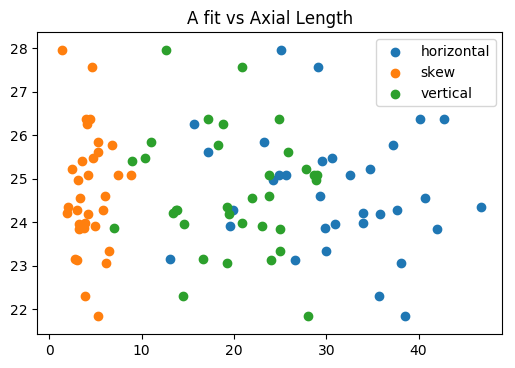

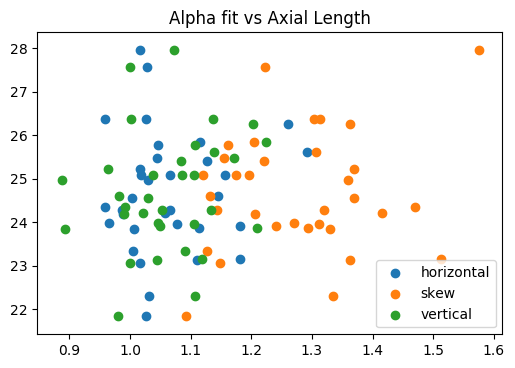

In [19]:
#plot a fits

al_horiz = al_fits[al_fits['direction']=='horizontal']
plt.scatter(al_horiz['a'], np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='horizontal')

al_skew = al_fits[al_fits['direction']=='skew']
plt.scatter(al_skew['a'], np.max([al_skew['AL_OD'],al_skew['AL_OS']],axis=0),label='skew')

al_vert = al_fits[al_fits['direction']=='vertical']
plt.scatter(al_vert['a'], np.max([al_vert['AL_OD'],al_vert['AL_OS']],axis=0),label='vertical')

plt.legend()
plt.title('A fit vs Axial Length')


#plot a
plt.figure()

plt.scatter(al_horiz['alpha'], np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='horizontal')
plt.scatter(al_skew['alpha'], np.max([al_skew['AL_OD'],al_skew['AL_OS']],axis=0),label='skew')
plt.scatter(al_vert['alpha'], np.max([al_vert['AL_OD'],al_vert['AL_OS']],axis=0),label='vertical')

plt.legend()
plt.title('Alpha fit vs Axial Length')


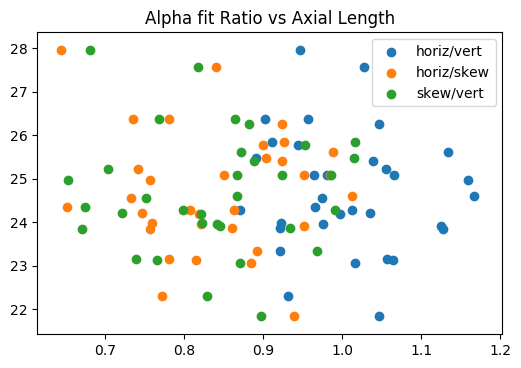

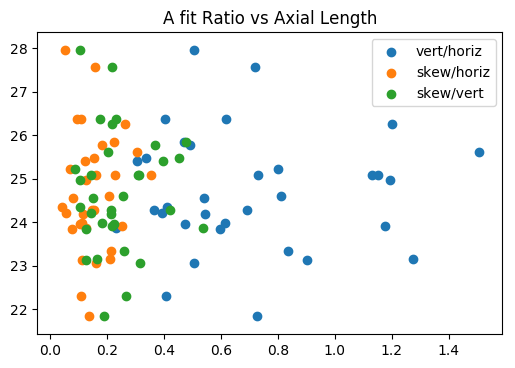

In [20]:
plt.scatter(np.divide(al_horiz['alpha'],al_vert['alpha']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='horiz/vert')
plt.scatter(np.divide(al_horiz['alpha'],al_skew['alpha']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='horiz/skew')
plt.scatter(np.divide(al_vert['alpha'],al_skew['alpha']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='skew/vert')
plt.legend()
plt.title('Alpha fit Ratio vs Axial Length')

plt.figure()
plt.scatter(np.divide(al_vert['a'],al_horiz['a']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='vert/horiz')
plt.scatter(np.divide(al_skew['a'],al_horiz['a']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='skew/horiz')
plt.scatter(np.divide(al_skew['a'],al_vert['a']), np.max([al_horiz['AL_OD'],al_horiz['AL_OS']],axis=0),label='skew/vert')
plt.legend()
plt.title('A fit Ratio vs Axial Length')

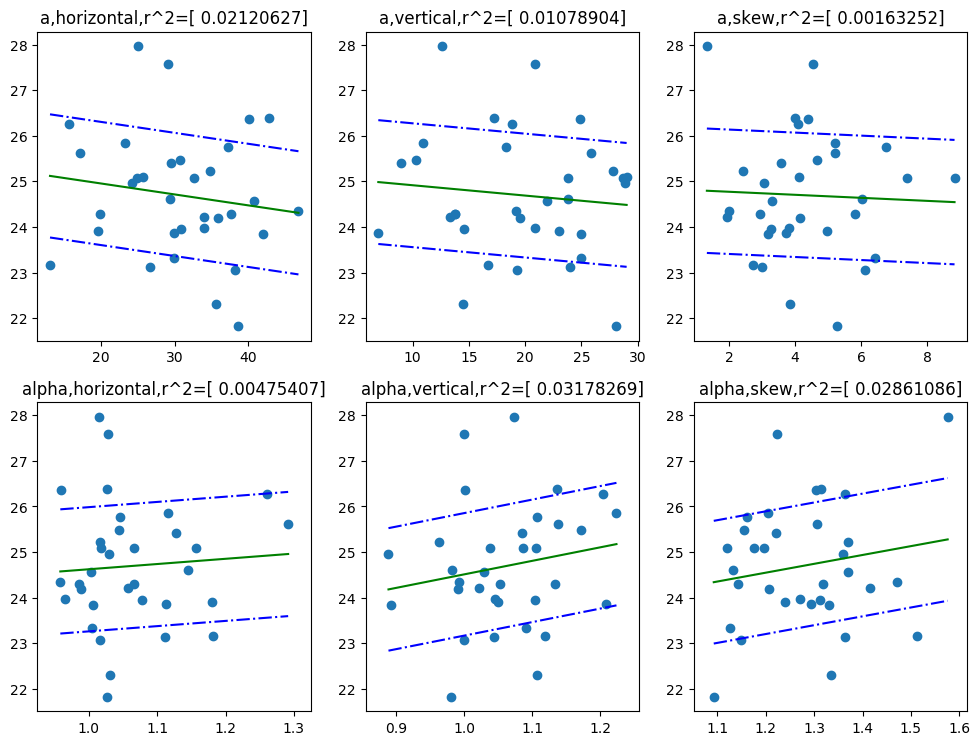

In [280]:
def regression_fitter(x,y,my_axes,val,direction):
    z = np.polyfit(x,y,deg=1,full=True)
    m_h = z[0][0]
    b_h = z[0][1]
    sse = z[1]#[0]
    rsq = 1-sse/np.sum((y-np.mean(y))**2)
    fit = np.array(m_h*x+b_h)
    err_h = np.abs(y-fit)
    se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
    sem = se/np.sqrt(len(x))
    xlsp = np.linspace(np.min(x), np.max(x),50)
    ylsp = xlsp*m_h+b_h
    my_axes.plot(xlsp,ylsp,'g')
    my_axes.plot(xlsp,ylsp+se,'b-.')
    my_axes.plot(xlsp,ylsp-se,'b-.')
    my_axes.set_title('{:},{:},r^2={:}'.format(val, direction, rsq))
    return(my_axes)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in ['horizontal','vertical','skew']:
        #plot fits
        plt.figure();
        vals = al_fits[al_fits['direction']==direction]
        xs = vals[val]
        ys = np.max([vals['AL_OD'],vals['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1



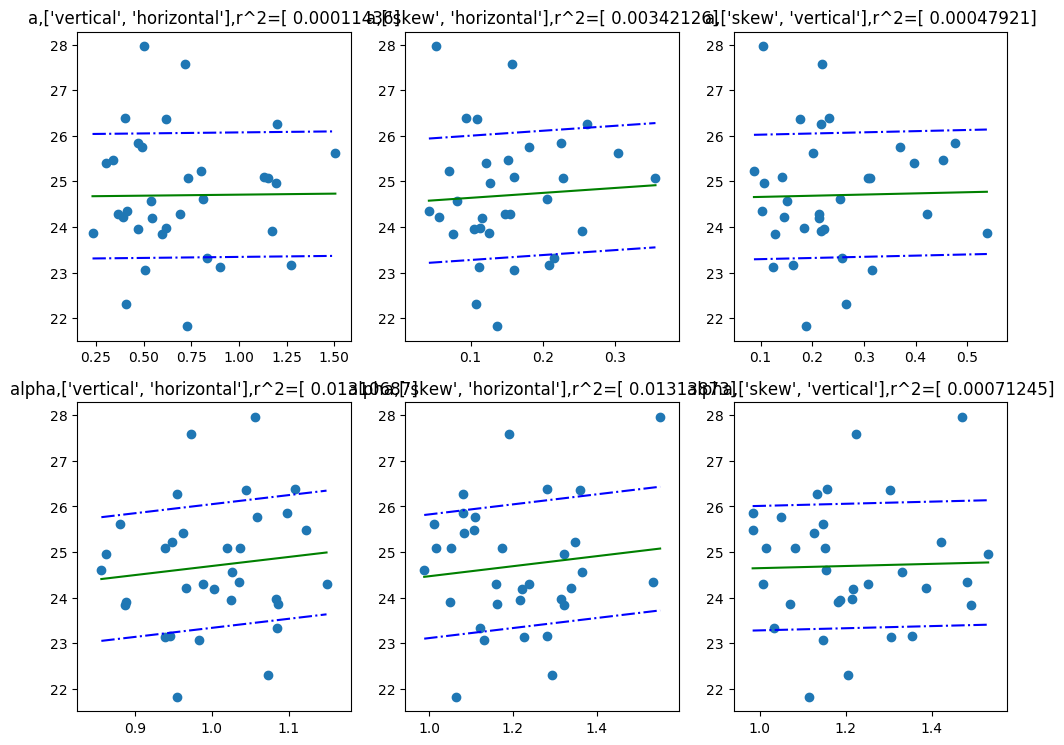

In [281]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in [['vertical','horizontal'],['skew','horizontal'],['skew','vertical']]:
        #plot fits
        plt.figure()
        vals_num = al_fits[al_fits['direction']==direction[0]]
        vals_denom = al_fits[al_fits['direction']==direction[1]]
        xs = np.divide(vals_num[val],vals_denom[val])
        ys = np.max([vals_num['AL_OD'],vals_num['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1


## Analyze ACA and NACA Fits Separately

In [51]:
al_period_fits = pd.DataFrame(columns = ('subject','period','direction','a','a_se','alpha','alpha_se','AL_OD','AL_OS'))


i=0
for sub in subjects:
    for period in ['aca','naca']:
        if(period in ddict[sub].keys()):
            for direction in ['vertical','horizontal','skew']:
                a = ddict[sub][period]['avgim_a_{}'.format(direction)]
                a_se = ddict[sub][period]['avgim_a_se_{}'.format(direction)]
                alpha = ddict[sub][period]['avgim_alpha_{}'.format(direction)]
                alpha_se = ddict[sub][period]['avgim_alpha_se_{}'.format(direction)]
                al_od = np.mean(als.loc[sub][['NACA OD AL','ACA OD AL']])
                al_os = np.mean(als.loc[sub][['NACA OS AL','ACA OS AL']])
                al_period_fits.loc[i] = ([sub, period, direction, a, a_se, alpha, alpha_se, al_od, al_os])
                i+=1
al_period_fits

subject period   direction          a      a_se     alpha  alpha_se  \
0    AG102816    aca    vertical  13.787791  1.122317  1.132963  0.024553   
1    AG102816    aca  horizontal  37.634416  2.274476  0.986141  0.018878   
2    AG102816    aca        skew   5.820346  0.509168  1.143168  0.026107   
3    AH110515    aca    vertical  24.320350  2.780322  1.015783  0.035432   
4    AH110515    aca  horizontal  31.231197  2.477301  1.069575  0.024260   
5    AH110515    aca        skew   2.347086  0.294859  1.449435  0.035694   
6    AH110515   naca    vertical  21.047272  2.451301  1.095311  0.035419   
7    AH110515   naca  horizontal  16.602569  2.017342  1.208857  0.036113   
8    AH110515   naca        skew   4.358368  0.505456  1.183873  0.034330   
9    AN120915    aca    vertical   7.686923  0.858769  1.184498  0.033352   
10   AN120915    aca  horizontal  18.999787  1.679613  1.093897  0.026892   
11   AN120915    aca        skew   4.568352  0.426824  1.128656  0.027965   
12   AN120915   naca    vertical  14.405078  1.499058  1.157500  0.031234   
13   AN120915   naca  horizontal  51.023716  4.776259  0.994839  0.029173   
14   AN120915   naca        skew   4.475023  0.493123  1.194037  0.032547   
15   CH121015   naca    vertical   8.976612  1.262452  1.084534  0.042873   
16   CH121015   naca  horizontal  29.535540  3.679582  1.127342  0.037623   
17   CH121015   naca        skew   3.565814  0.306561  1.220607  0.025271   
18   CM021816    aca    vertical  28.656052  2.243718  1.104956  0.023760   
19   CM021816    aca  horizontal  24.857238  2.047739  1.066366  0.025219   
20   CM021816    aca        skew   8.836562  0.547015  1.120640  0.018562   
21   DC080615   naca    vertical  13.354502  1.918235  1.021055  0.044454   
22   DC080615   naca  horizontal  34.010051  3.402247  1.056813  0.030693   
23   DC080615   naca        skew   1.934407  0.216851  1.415022  0.031997   
24   DG110915    aca    vertical  20.908247  4.177229  1.045716  0.061464   
25   DG110915    aca  horizontal  33.978893  3.100864  0.965508  0.028668   
26   DG110915    aca        skew   3.826606  0.559635  1.270516  0.042635   
27   GG073115   naca    vertical   6.938877  0.802530  1.208645  0.034370   
28   GG073115   naca  horizontal  29.897857  2.892867  1.113452  0.029309   
29   GG073115   naca        skew   3.733888  0.509274  1.293914  0.039618   
..        ...    ...         ...        ...       ...       ...       ...   
108  NS091015    aca    vertical  29.021451  3.880493  1.037376  0.041220   
109  NS091015    aca  horizontal  25.682118  3.885884  1.017672  0.046863   
110  NS091015    aca        skew   4.127407  0.494250  1.195734  0.035365   
111  PS102015    aca    vertical  11.589240  1.463122  1.150488  0.037942   
112  PS102015    aca  horizontal  18.537416  3.277379  1.180250  0.052824   
113  PS102015    aca        skew   1.878208  0.295669  1.502045  0.044468   
114  PS102015   naca    vertical  26.420960  2.575935  1.005830  0.030297   
115  PS102015   naca  horizontal  16.294911  1.376416  1.181319  0.025232   
116  PS102015   naca        skew   6.839911  0.519917  1.096357  0.022909   
117  SB101416    aca    vertical  14.583401  1.589018  1.104722  0.033064   
118  SB101416    aca  horizontal  30.894897  2.337494  1.077811  0.023101   
119  SB101416    aca        skew   3.251355  0.452650  1.311741  0.040317   
120  SG021116    aca    vertical  21.954649  2.035145  1.029125  0.028629   
121  SG021116    aca  horizontal  40.699410  2.804158  1.003165  0.021428   
122  SG021116    aca        skew   3.306199  0.299472  1.369272  0.026016   
123  SZ091115    aca    vertical  33.116866  5.232814  0.863381  0.051182   
124  SZ091115    aca  horizontal  40.732265  4.867671  1.018383  0.037016   
125  SZ091115    aca        skew   6.652587  0.904054  1.170724  0.040331   
126  SZ091115   naca    vertical  15.381656  1.731326  1.055429  0.034550   
127  SZ091115   naca  horizontal  19.803327  1.787615  1.210816  0.026816   
12

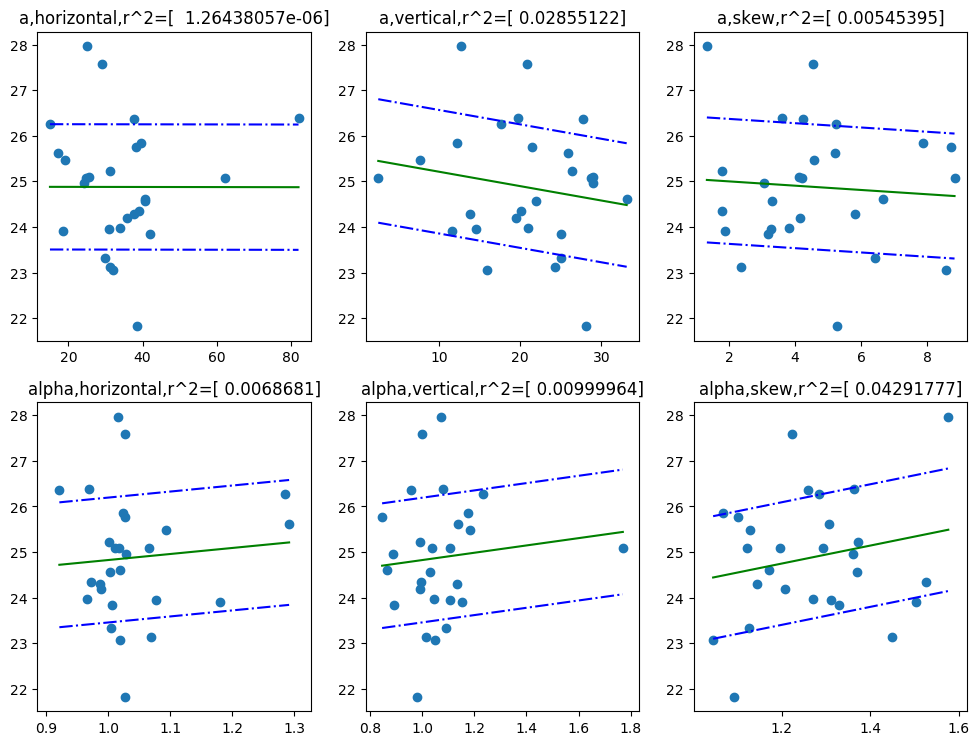

In [52]:
##ACADEMIC PERIOD

fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns

period = 'aca'
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in ['horizontal','vertical','skew']:
        #plot fits
        plt.figure()
        vals = al_period_fits[(al_period_fits['direction']==direction) & (al_period_fits['period']==period)]
        xs = vals[val]
        ys = np.max([vals['AL_OD'],vals['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1

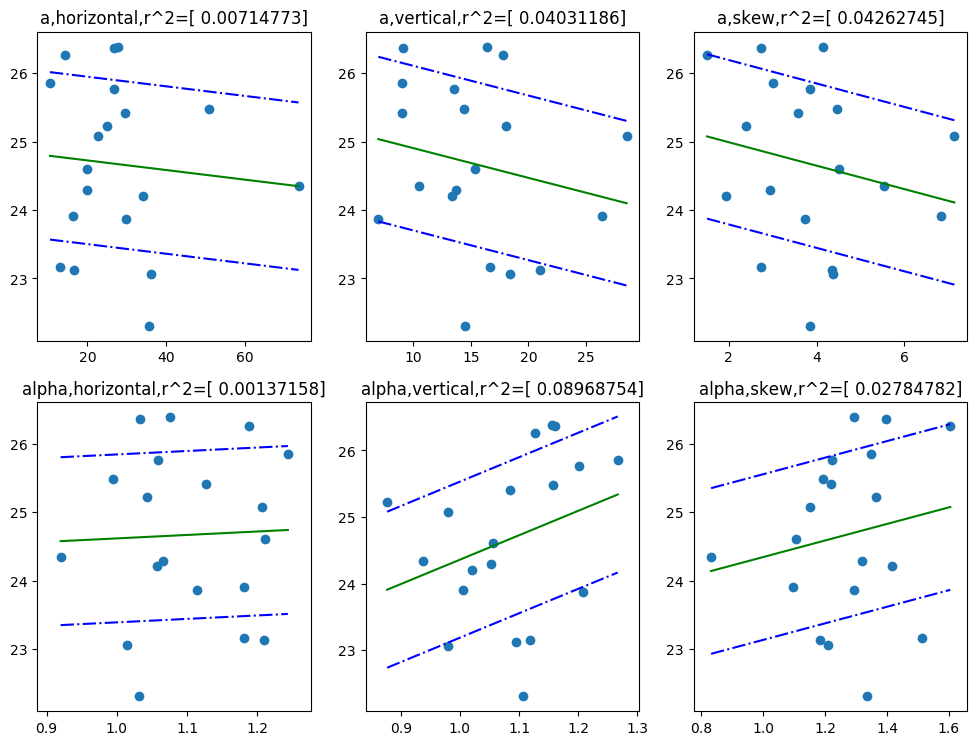

In [53]:
##NON ACADEMIC PERIOD

fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns

period = 'naca'
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in ['horizontal','vertical','skew']:
        #plot fits
        plt.figure()
        vals = al_period_fits[(al_period_fits['direction']==direction) & (al_period_fits['period']==period)]
        xs = vals[val]
        ys = np.max([vals['AL_OD'],vals['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1

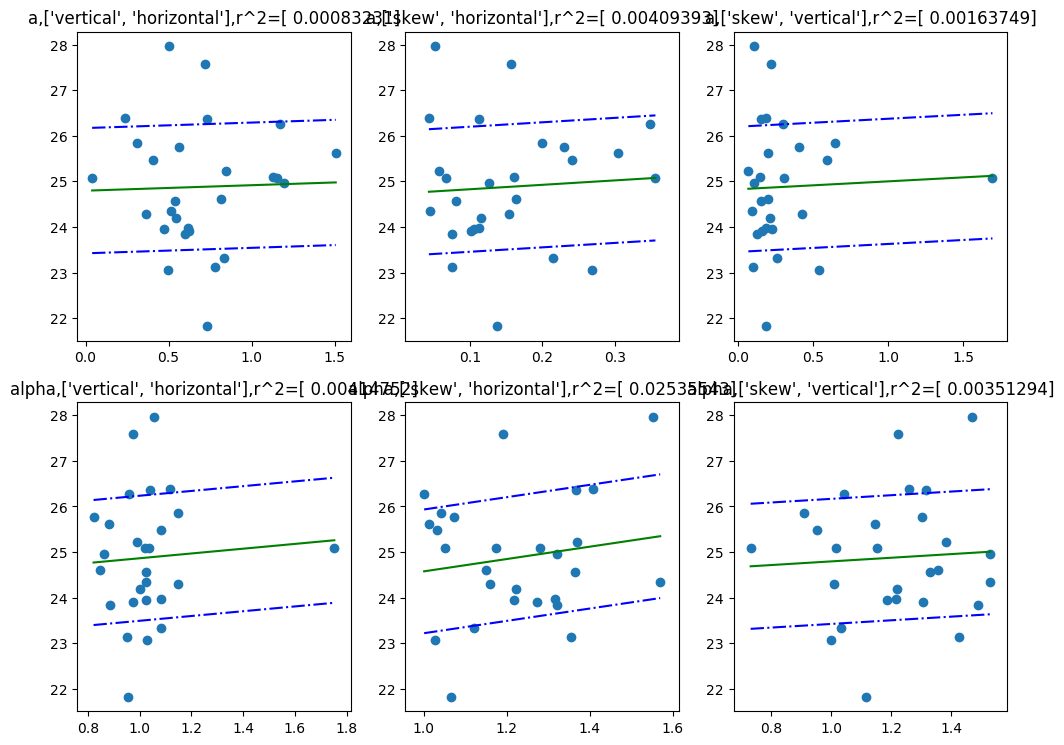

In [54]:
##ACADEMIC PERIOD - ratio

fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns

period = 'aca'
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in [['vertical','horizontal'],['skew','horizontal'],['skew','vertical']]:
        #plot fits
        plt.figure()
        vals_num = al_period_fits[(al_period_fits['direction']==direction[0]) &(al_period_fits['period']==period)]
        vals_denom = al_period_fits[(al_period_fits['direction']==direction[1]) &(al_period_fits['period']==period)]
        xs = np.divide(vals_num[val],vals_denom[val])
        ys = np.max([vals_num['AL_OD'],vals_num['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1
    


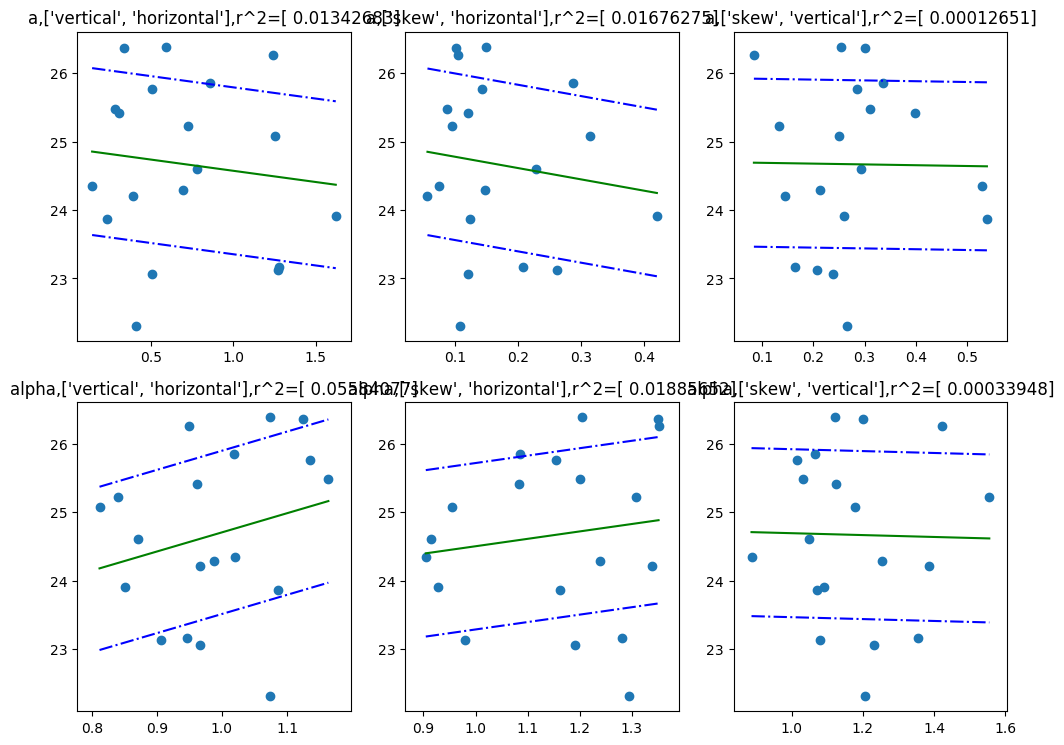

In [55]:
##NON ACADEMIC PERIOD - Ratio

fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns

period = 'naca'
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in [['vertical','horizontal'],['skew','horizontal'],['skew','vertical']]:
        #plot fits
        plt.figure()
        vals_num = al_period_fits[(al_period_fits['direction']==direction[0]) &(al_period_fits['period']==period)]
        vals_denom = al_period_fits[(al_period_fits['direction']==direction[1]) &(al_period_fits['period']==period)]
        xs = np.divide(vals_num[val],vals_denom[val])
        ys = np.max([vals_num['AL_OD'],vals_num['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1

## Compare ACA and NACA fits for each subject in both categories with Axial Length

In [56]:
aca_naca_df = pd.DataFrame(columns = ('subject','direction','period','a','a_se','alpha','alpha_se','AL_OD','AL_OS'))
    
i=0
for sub in subjects:
    if (('aca' in ddict[sub].keys()) & ('naca' in ddict[sub].keys())):
        for period in ['aca','naca']:
            for direction in ['vertical','horizontal','skew']:
                a = ddict[sub][period]['avgim_a_{}'.format(direction)]
                a_se = ddict[sub][period]['avgim_a_se_{}'.format(direction)]
                alpha = ddict[sub][period]['avgim_alpha_{}'.format(direction)]
                alpha_se = ddict[sub][period]['avgim_alpha_se_{}'.format(direction)]
                al_od = np.mean(als.loc[sub][['NACA OD AL','ACA OD AL']])
                al_os = np.mean(als.loc[sub][['NACA OS AL','ACA OS AL']])
                aca_naca_df.loc[i] = ([sub, direction, period, a, a_se, alpha, alpha_se, al_od, al_os])
                i+=1
aca_naca_df

subject   direction period          a       a_se     alpha  alpha_se  \
0   AH110515    vertical    aca  24.320350   2.780322  1.015783  0.035432   
1   AH110515  horizontal    aca  31.231197   2.477301  1.069575  0.024260   
2   AH110515        skew    aca   2.347086   0.294859  1.449435  0.035694   
3   AH110515    vertical   naca  21.047272   2.451301  1.095311  0.035419   
4   AH110515  horizontal   naca  16.602569   2.017342  1.208857  0.036113   
5   AH110515        skew   naca   4.358368   0.505456  1.183873  0.034330   
6   AN120915    vertical    aca   7.686923   0.858769  1.184498  0.033352   
7   AN120915  horizontal    aca  18.999787   1.679613  1.093897  0.026892   
8   AN120915        skew    aca   4.568352   0.426824  1.128656  0.027965   
9   AN120915    vertical   naca  14.405078   1.499058  1.157500  0.031234   
10  AN120915  horizontal   naca  51.023716   4.776259  0.994839  0.029173   
11  AN120915        skew   naca   4.475023   0.493123  1.194037  0.032547   
12  HL110215    vertical    aca   2.482344   1.112905  1.770349  0.124597   
13  HL110215  horizontal    aca  62.340014  13.187814  1.010309  0.065661   
14  HL110215        skew    aca   4.206770   0.877421  1.292944  0.060576   
15  HL110215    vertical   naca  28.546374   1.963992  0.979145  0.021532   
16  HL110215  horizontal   naca  22.749036   2.337558  1.206047  0.030552   
17  HL110215        skew   naca   7.142470   0.609829  1.152435  0.025430   
18  JC101615    vertical    aca  15.946531   2.228308  1.047102  0.042974   
19  JC101615  horizontal    aca  32.011298   2.790290  1.018869  0.026996   
20  JC101615        skew    aca   8.586985   1.028933  1.045160  0.036551   
21  JC101615    vertical   naca  18.364997   1.554976  0.980328  0.026491   
22  JC101615  horizontal   naca  36.146041   2.397645  1.014945  0.020564   
23  JC101615        skew   naca   4.384326   0.402678  1.208245  0.027063   
24  JC102715    vertical    aca  19.702748   2.383364  1.081191  0.036906   
25  JC102715  horizontal    aca  82.118654   8.878006  0.968591  0.033932   
26  JC102715        skew    aca   3.592997   0.593739  1.363395  0.047493   
27  JC102715    vertical   naca  16.406478   1.640249  1.154802  0.030021   
28  JC102715  horizontal   naca  27.798180   2.506015  1.075434  0.027539   
29  JC102715        skew   naca   4.154523   0.368064  1.294678  0.025724   
..       ...         ...    ...        ...        ...       ...       ...   
48  LS073115    vertical    aca  17.599277   2.386762  1.231649  0.040137   
49  LS073115  horizontal    aca  15.014339   2.250496  1.284095  0.043970   
50  LS073115        skew    aca   5.231580   0.473716  1.285049  0.026332   
51  LS073115    vertical   naca  17.823889   2.860326  1.127619  0.048472   
52  LS073115  horizontal   naca  14.354101   2.339715  1.187485  0.048634   
53  LS073115        skew   naca   1.503115   0.281813  1.604333  0.052408   
54  LW072415    vertical    aca  27.709885   2.434747  0.957090  0.027663   
55  LW072415  horizontal    aca  37.790277   3.145153  0.921309  0.026479   
56  LW072415        skew    aca   4.237897   0.347990  1.259967  0.023978   
57  LW072415    vertical   naca   9.083496   1.151047  1.161306  0.038002   
58  LW072415  horizontal   naca  26.853891   2.950887  1.033296  0.033909   
59  LW072415        skew   naca   2.733916   0.352515  1.395211  0.036906   
60  ML072115    vertical    aca  20.092029   1.736899  0.996648  0.026928   
61  ML072115  horizontal    aca  39.123679   3.859207  0.971500  0.030932   
62  ML072115        skew    aca   1.790060   0.175327  1.524834  0.027597   
63  ML072115    vertical   naca  10.455258   0.890883  0.937846  0.026979   
64  ML072115  horizontal   naca  73.681320   9.608953  0.920062  0.041506   
65  ML072115        skew   naca   5.527989   0.701239  0.832268  0.041188   
66  PS102015    vertical    aca  11.589240   1.463122  1.150488  0.037942   
67  PS102015  horizontal    aca  18.537416   3.277379  1.180250  0.052824   
6

[1.881106326701792, 0.372371679376065, 2.740336524541229, 0.8856100707829817, 2.9541018011852653, 1.4188393708108185, 3.784526756707294, 1.2494408637064913, 1.0459964374095716, 1.407255181119278, 0.5309850491292353, 1.137620008877743, 2.0568394465463076]
[0.5385241712669138, 1.020855428776409, 0.5889796753948529, 1.9585643303483615, 0.8648400414992286, 2.2658638792127395, 2.6261005060789353, 0.7491192292517248, 3.4804932451070645, 1.550119540763775, 0.32381753117566564, 0.27459541436499274, 1.4732252780357555]
[1.1555107605622454, 0.533625911847391, 0.086958288895553, 0.8683110951451829, 1.200912673015914, 1.586344268632832, 1.3631674767614135, 1.457695687277466, 0.9873982612845057, 3.0505748867712015, 1.921715247255826, 0.43863812204219027, 2.1530105153547034]


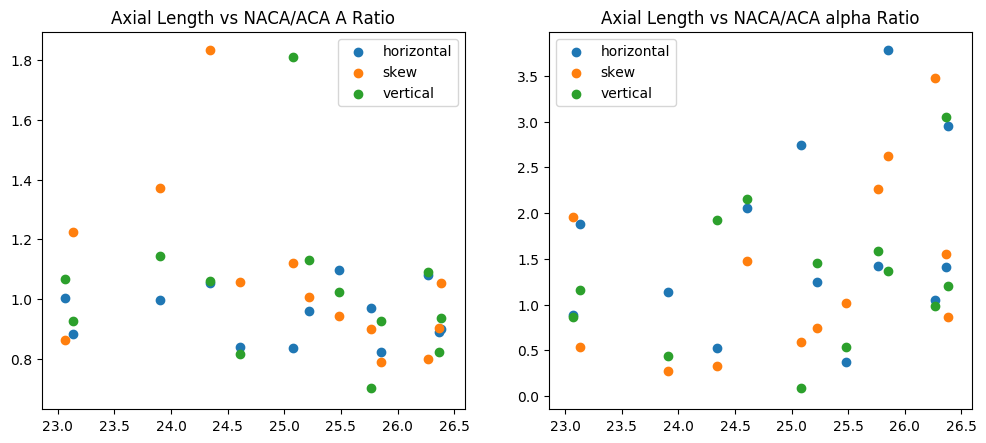

In [57]:
#plot a fits
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,5))
for dirc in ['horizontal','skew','vertical']:
    a_ratios = []
    alpha_ratios = []
    axials = []

    for sub in np.unique(aca_naca_df['subject']):
        #df[df['first_name'].notnull() & (df['nationality'] == "USA")]
        subtable = aca_naca_df[(aca_naca_df['subject']== sub) & (aca_naca_df['direction'] == dirc)]
        a_ratio = np.float(np.divide(subtable[subtable['period']=='aca']['a'],
                            subtable[subtable['period']=='naca']['a']))
        alpha_ratio = np.float(np.divide(subtable[subtable['period']=='aca']['alpha'],
                               subtable[subtable['period']=='naca']['alpha']))        
        a_ratios.append(a_ratio)
        alpha_ratios.append(alpha_ratio)

        al = np.max([subtable['AL_OD'].iloc[0],subtable['AL_OS'].iloc[0]])
        axials.append(al)
        
        
    #print(axials)
    print(a_ratios)
    axes[0].scatter(axials,alpha_ratios,label=dirc)
    axes[1].scatter(axials,a_ratios,label=dirc)

axes[0].legend()
axes[0].set_title('Axial Length vs NACA/ACA A Ratio')
axes[1].legend()
axes[1].set_title('Axial Length vs NACA/ACA alpha Ratio')

[14.628628543489942, -32.02392918681006, 39.59097790844106, -4.134743062089129, 54.32047365571873, 11.251692411363209, 29.13867762802191, 6.242766407725959, 0.6602375208347073, 10.936386194811483, -34.55764070921086, 2.242505738403956, 20.928937387308846]
[-2.011281444447219, 0.09332852982775286, -2.935700454551534, 4.202658813777359, -0.5615250897346717, 4.879569431392282, 4.886838927961034, -0.5994637944254133, 3.728465801538568, 1.503980811292429, -3.7379290535904612, -4.9617028524579965, 2.136925135449756]
[3.273077340506557, -6.718155050557424, -26.064030062325035, -2.4184663416990393, 3.2962694297951245, 7.926384225862044, 3.253464508082221, 8.269605277250783, -0.2246119917390743, 18.626389133168338, 9.636770688450403, -14.831719856427096, 17.735210630722825]


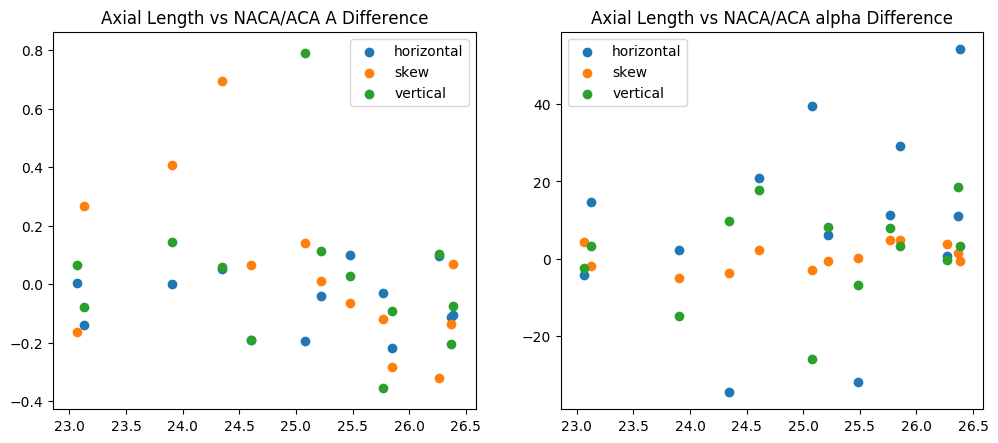

In [58]:
#plot a fits
fig, axes = plt.subplots(nrows=1, ncols=2, figsize =(12,5))
for dirc in ['horizontal','skew','vertical']:
    a_diffs = []
    alpha_diffs = []
    axials = []

    for sub in np.unique(aca_naca_df['subject']):
        #df[df['first_name'].notnull() & (df['nationality'] == "USA")]
        subtable = aca_naca_df[(aca_naca_df['subject']== sub) & (aca_naca_df['direction'] == dirc)]
        a_diff = np.float(np.subtract(subtable[subtable['period']=='aca']['a'],
                            subtable[subtable['period']=='naca']['a']))
        alpha_diff = np.float(np.subtract(subtable[subtable['period']=='aca']['alpha'],
                               subtable[subtable['period']=='naca']['alpha']))        
        a_diffs.append(a_diff)
        alpha_diffs.append(alpha_diff)

        al = np.max([subtable['AL_OD'].iloc[0],subtable['AL_OS'].iloc[0]])
        axials.append(al)
        
        
    #print(axials)
    print(a_diffs)
    axes[0].scatter(axials,alpha_diffs,label=dirc)
    axes[1].scatter(axials,a_diffs,label=dirc)

axes[0].legend()
axes[0].set_title('Axial Length vs NACA/ACA A Difference')
axes[1].legend()
axes[1].set_title('Axial Length vs NACA/ACA alpha Difference')

## Note in the above result that this is based on only 4 subjects and 1-2 images per subject's academic period. We need more data here, or at least to take these results wiht a grain of salt.

## A Possibly Hair-Brained Idea about Color

(884, 3000, 3)


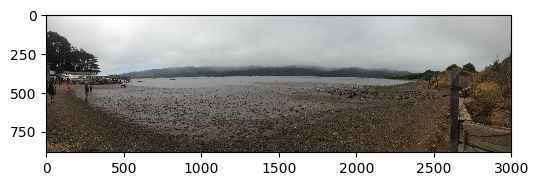

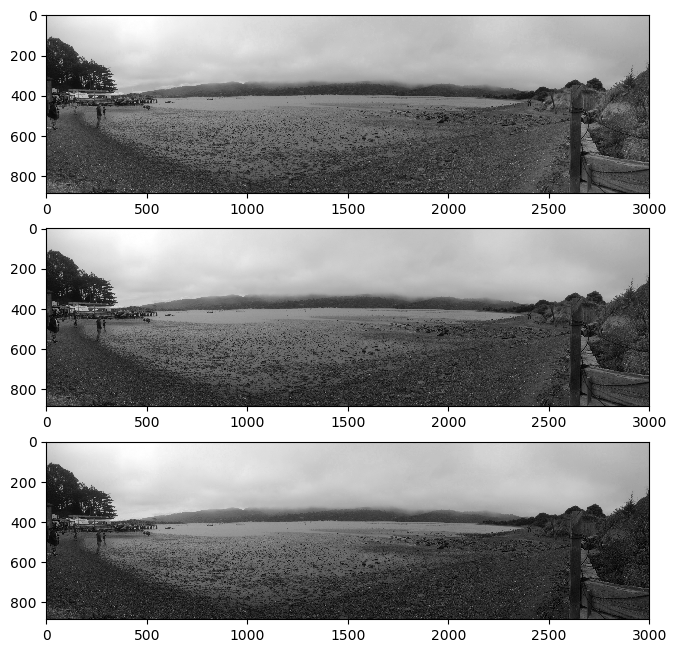

In [113]:
exim = ddict[emm_sub]['naca']['images_raw'][0]
plt.imshow(exim);
print(exim.shape)
r = exim[:,:,0]
g =  exim[:,:,1]
b =  exim[:,:,2]

plt.figure(figsize=(15,8));
plt.subplot(3,1,1)
plt.imshow(r,cmap='gray')
plt.subplot(3,1,2)
plt.imshow(g,cmap='gray')
plt.subplot(3,1,3)
plt.imshow(b,cmap='gray')


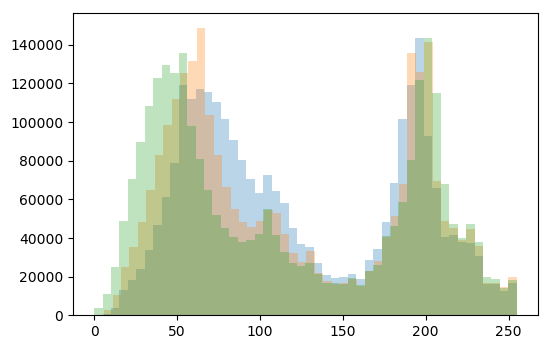

In [114]:
plt.hist(r.flatten(), bins=50, alpha = 0.3);
plt.hist(g.flatten(), bins=50, alpha = 0.3);
plt.hist(b.flatten(), bins=50, alpha = 0.3);

In [197]:
ddict['AH110515']['naca'].keys()

dict_keys(['images_raw', 'rgb', 'images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew'])

In [269]:
al_period_color_fits = pd.DataFrame(columns = ('subject','period','r','g','b','AL_OD','AL_OS'))

i=0
for sub in subjects:
    for period in ['aca','naca']:
        if(period in ddict[sub].keys()):
            rgbims = ddict[sub][period]['rgb']
            for rgb in rgbims:
                #print(rgb)
                r = rgb[0]
                g = rgb[1]
                b = rgb[2]
                al_od = np.mean(als.loc[sub][['NACA OD AL','ACA OD AL']])
                al_os = np.mean(als.loc[sub][['NACA OS AL','ACA OS AL']])
                al_period_color_fits.loc[i] = ([sub, period, r, g, b, al_od, al_os])
                i+=1
al_period_color_fits


subject period         r         g         b   AL_OD   AL_OS
0    AG102816    aca  1.060329  0.978380  0.961290  24.180  24.290
1    AG102816    aca  1.111444  0.958267  0.930289  24.180  24.290
2    AG102816    aca  0.977259  1.025335  0.997406  24.180  24.290
3    AG102816    aca  0.983888  1.027590  0.988522  24.180  24.290
4    AG102816    aca  1.020807  1.009199  0.969994  24.180  24.290
5    AG102816    aca  1.041629  1.013693  0.944677  24.180  24.290
6    AH110515    aca  1.038001  1.001621  0.960377  23.110  23.130
7    AH110515    aca  0.941660  0.989382  1.068958  23.110  23.130
8    AH110515    aca  1.018134  1.000624  0.981242  23.110  23.130
9    AH110515    aca  0.924521  0.990499  1.084980  23.110  23.130
10   AH110515    aca  0.975391  0.995905  1.028704  23.110  23.130
11   AH110515    aca  1.006779  0.983157  1.010064  23.110  23.130
12   AH110515   naca  0.985000  0.971917  1.043083  23.110  23.130
13   AH110515   naca  1.024306  0.997759  0.977935  23.110  23.130
14   AH110515   naca  1.098581  1.011034  0.890385  23.110  23.130
15   AN120915    aca  0.835843  1.047808  1.116349  25.155  25.480
16   AN120915    aca  0.785510  1.048322  1.166168  25.155  25.480
17   AN120915    aca  0.970486  1.092020  0.937494  25.155  25.480
18   AN120915    aca  1.029428  1.105825  0.864747  25.155  25.480
19   AN120915    aca  0.987136  1.054879  0.957985  25.155  25.480
20   AN120915    aca  1.121460  1.111651  0.766889  25.155  25.480
21   AN120915   naca  1.085772  1.023175  0.891053  25.155  25.480
22   AN120915   naca  0.989365  1.065833  0.944802  25.155  25.480
23   AN120915   naca  0.985187  1.037475  0.977338  25.155  25.480
24   CH121015   naca  1.027275  1.014839  0.957885  25.000  25.410
25   CH121015   naca  1.145822  1.066581  0.787597  25.000  25.410
26   CH121015   naca  1.072557  1.050775  0.876668  25.000  25.410
27   CM021816    aca  1.026095  1.035986  0.937919  25.070  25.080
28   CM021816    aca  0.969021  0.991317  1.039663  25.070  25.080
29   CM021816    aca  0.983723  0.999636  1.016641  25.070  25.080
..        ...    ...       ...       ...       ...     ...     ...
172  SB101416    aca  1.069541  1.016668  0.913792  23.950  23.770
173  SB101416    aca  1.047952  1.017857  0.934191  23.950  23.770
174  SG021116    aca  0.885501  0.967714  1.146785  24.500  24.560
175  SG021116    aca  0.974392  0.992328  1.033280  24.500  24.560
176  SG021116    aca  0.890079  0.969560  1.140361  24.500  24.560
177  SG021116    aca  0.881172  0.914457  1.204371  24.500  24.560
178  SG021116    aca  0.854805  0.984878  1.160317  24.500  24.560
179  SG021116    aca  0.888994  0.968830  1.142176  24.500  24.560
180  SZ091115    aca  0.902662  1.166093  0.931245  24.595  24.605
181  SZ091115    aca  1.007731  1.031488  0.960781  24.595  24.605
182  SZ091115   naca  0.884702  1.105593  1.009706  24.595  24.605
183  SZ091115   naca  0.977795  1.261476  0.760729  24.595  24.605
184  SZ091115   naca  1.021916  1.216157  0.761927  24.595  24.605
185  SZ091115   naca  0.760634  1.042751  1.196615  24.595  24.605
186  SZ091115   naca  0.786226  1.026103  1.187671  24.595  24.605
187  TE072715   naca  1.066509  1.024163  0.909328  24.270  24.290
188  TE072715   naca  0.930462  1.066613  1.002925  24.270  24.290
189  TE072715   naca  1.019684  1.039902  0.940414  24.270  24.290
190  VP041416    aca  1.011484  1.015388  0.973128  27.960  27.940
191  VP041416    aca  0.995630  1.024035  0.980335  27.960  27.940
192  VP041416    aca  0.938458  0.989230  1.072312  27.960  27.940
193  VP041416    aca  0.959414  1.014821  1.025764  27.960  27.940
194  VP041416    aca  1.010896  1.045645  0.943459  27.960  27.940
195  VP041416    aca  0.972386  1.065852  0.961762  27.960  27.940
196  WO021616    aca  0.912748  1.017994  1.069259  25.620  25.550
197  WO021616    aca  0.897894  1.022055  1.080051  25.620  25.550
198  WO021616    aca  0.984247  1.194317  0.821435  25.620  25.550
199  WO021616    aca  0.930490  1.064465  1.005045  2

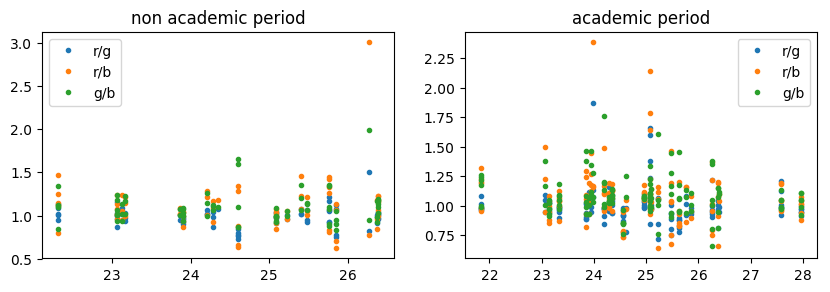

In [274]:
# Overall Color ratios vs axial length
naca_color_fits = al_period_color_fits[al_period_color_fits['period']=='naca']
aca_color_fits = al_period_color_fits[al_period_color_fits['period']=='aca']

#color ratio
naca_rb_ratio = naca_color_fits['r']/naca_color_fits['b']
naca_rg_ratio = naca_color_fits['r']/naca_color_fits['g']
naca_gb_ratio = naca_color_fits['g']/naca_color_fits['b']

aca_rb_ratio = aca_color_fits['r']/aca_color_fits['b']
aca_rg_ratio = aca_color_fits['r']/aca_color_fits['g']
aca_gb_ratio = aca_color_fits['g']/aca_color_fits['b']

#axial len
naca_axlen = np.max([naca_color_fits['AL_OD'], naca_color_fits['AL_OS']],axis=0)
aca_axlen = np.max([aca_color_fits['AL_OD'], aca_color_fits['AL_OS']],axis=0)

plt.figure(figsize=(10,3));
plt.subplot(1,2,1);
plt.plot(naca_axlen, naca_rg_ratio, '.',label='r/g');
plt.plot(naca_axlen, naca_rb_ratio, '.',label='r/b');
plt.plot(naca_axlen, naca_gb_ratio, '.',label='g/b');

plt.title('non academic period');
plt.legend();

plt.subplot(1,2,2);
plt.plot(aca_axlen, aca_rg_ratio, '.',label='r/g');
plt.plot(aca_axlen, aca_rb_ratio, '.',label='r/b');
plt.plot(aca_axlen, aca_gb_ratio, '.',label='g/b');

plt.title('academic period');
plt.legend();

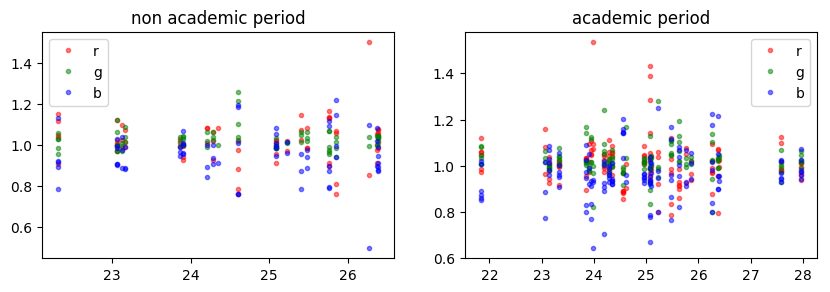

In [279]:
# Overall Color ratios vs axial length
naca_color_fits = al_period_color_fits[al_period_color_fits['period']=='naca']
aca_color_fits = al_period_color_fits[al_period_color_fits['period']=='aca']

#color ratio
naca_rb_ratio = naca_color_fits['r']/naca_color_fits['b']
naca_rg_ratio = naca_color_fits['r']/naca_color_fits['g']
naca_gb_ratio = naca_color_fits['g']/naca_color_fits['b']

aca_rb_ratio = aca_color_fits['r']/aca_color_fits['b']
aca_rg_ratio = aca_color_fits['r']/aca_color_fits['g']
aca_gb_ratio = aca_color_fits['g']/aca_color_fits['b']

#axial len
naca_axlen = np.max([naca_color_fits['AL_OD'], naca_color_fits['AL_OS']],axis=0)
aca_axlen = np.max([aca_color_fits['AL_OD'], aca_color_fits['AL_OS']],axis=0)

plt.figure(figsize=(10,3));
plt.subplot(1,2,1);
plt.plot(naca_axlen, naca_color_fits['r'], '.', label='r', c='r', alpha=0.5);
plt.plot(naca_axlen, naca_color_fits['g'], '.', label='g', c='g', alpha=0.5);
plt.plot(naca_axlen, naca_color_fits['b'], '.', label='b', c='b', alpha=0.5);

plt.title('non academic period');
plt.legend();

plt.subplot(1,2,2);
plt.plot(aca_axlen, aca_color_fits['r'], '.', label='r', c='r', alpha=0.5);
plt.plot(aca_axlen, aca_color_fits['g'], '.', label='g', c='g', alpha=0.5);
plt.plot(aca_axlen, aca_color_fits['b'], '.', label='b', c='b', alpha=0.5);

plt.title('academic period');
plt.legend();

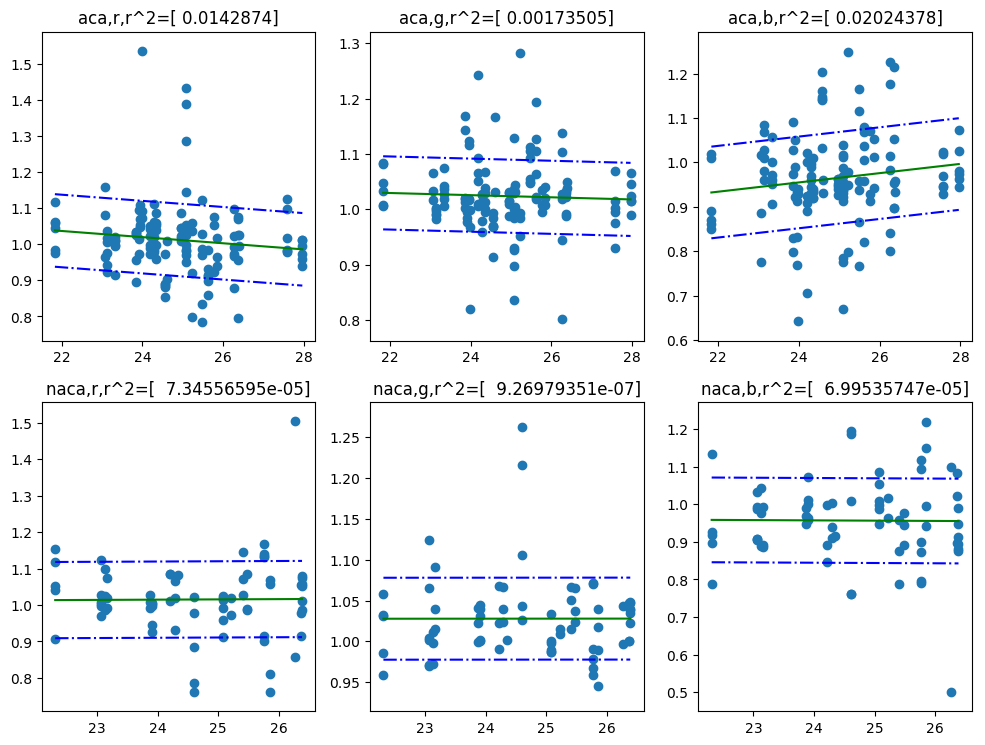

In [288]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9));
ix = 0 #index columns
for period in ['aca','naca']:
    df = al_period_color_fits[al_period_color_fits['period']==period]
    iy = 0 #index rows
    for color in ['r','g','b']:
        #plot fits
        plt.figure();
        ys = df[color]
        #xs = vals[color]
        xs = np.max([df['AL_OD'],df['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = 'Ratio of {}'.format(color)
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],period,color)
        iy+=1
    ix+=1

Turns out this isn't so hair brained: https://www.ncbi.nlm.nih.gov/pubmed/24222304

However, it's clear the data isn't show us anything to support this hypothesis.

# Notes from meeting with Elise:

**measure images independently because As may not match or normalize somehow - then we won't have a SE for our fits... **

**individual differences are more imporant. I think there is too little data do really do this**

**alpha difference value from aca to non aca for individual subjecgt within acsdrmic period.**

**how mauch varation do individuals have in their values for alpha and a - this is too little data I think...**

**how to top middle and bottom vary between each other for an individual subject? Moved instead to full scene analysis**

**dont take mean of both eyes. some are very different. Take longer eye val. %SUPER EASY**

**subsample large images instead of zooming in on large ones OR remove panaaramoics./ %TOP PRIOROTY **

**Analyze ACA and NACA AL values separately? YES **

**Compare these ALs to ACA and NACA photos separately? These don't seem to differ much **

## A few hand picked examples of differences between myopes and non-myopes


dict_keys(['AL', 'images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew', 'aca', 'naca'])


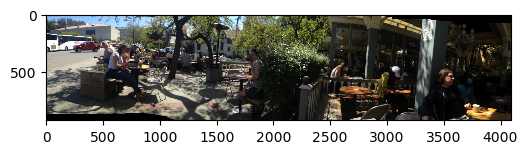

In [59]:
emm_sub = 'ML072115'
myo_sub = 'LW072415'
#plt.imshow(ddict[emm_sub]['naca']['images_raw'][0])
plt.imshow(ddict[myo_sub]['naca']['images_raw'][2])
print(ddict[emm_sub].keys())

In [60]:
#plot a few example images

emm_sub = 'ML072115'
myo_sub = 'LW072415'

tempdict = {}
tempdict[emm_sub] = {}
tempdict[myo_sub] = {}

#put images inside dictionary
emmim = ddict[emm_sub]['naca']['images_raw'][0]
myoim = ddict[myo_sub]['naca']['images_raw'][2]

tempdict[emm_sub]['images_raw'] = list([emmim])
tempdict[myo_sub]['images_raw'] = list([myoim])

mindim = min(emmim.shape[0], emmim.shape[1], myoim.shape[0], myoim.shape[1])

tempdict[emm_sub] = analyze_imset(tempdict[emm_sub]['images_raw'],
                                  mindim, tempdict[emm_sub], crop=False)
tempdict[myo_sub] = analyze_imset(tempdict[myo_sub]['images_raw'],
                                  mindim, tempdict[myo_sub], crop=False)

emm_alpha_h = tempdict[emm_sub]['avgim_alpha_horizontal']
myo_alpha_h = tempdict[myo_sub]['avgim_alpha_horizontal']
emm_alpha_v = tempdict[emm_sub]['avgim_alpha_vertical']
myo_alpha_v = tempdict[myo_sub]['avgim_alpha_vertical']

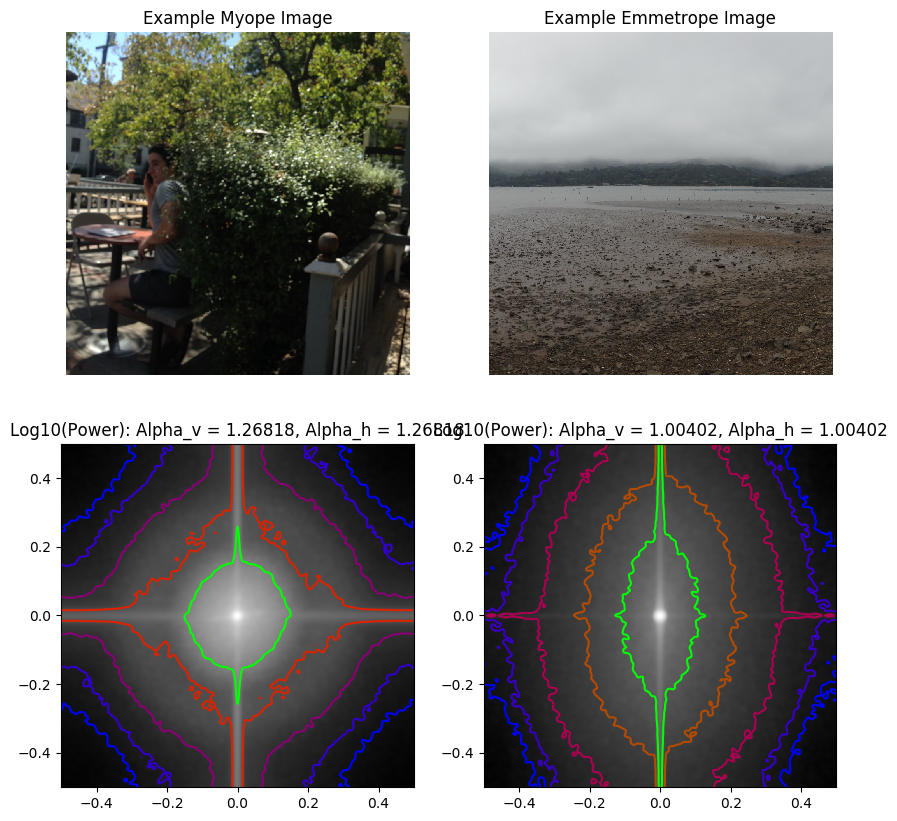

In [61]:
###NOTE SOMETHING WRONG WITH AVGIM_ALPHA_VERT AND AVGIM_ALPHA_HORIZ ARE SAME NUMBER. 
###DOUBLE CHECK THIS!!1

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1, title="Example Myope Image")
implot(tempdict[myo_sub]['avgim'])


plt.subplot(2, 2, 2, title="Example Emmetrope Image")
implot(tempdict[emm_sub]['avgim'])

plt.subplot(2, 2, 3, title='Log10(Power): Alpha_v = {1:.5f}, Alpha_h = {1:.5f}'.format(myo_alpha_h, myo_alpha_v))
contour_plotter(ps = tempdict[myo_sub]['avgim_ps'],
                fqs = tempdict[myo_sub]['avgim_fft_freqs'],
                bar=False)

plt.subplot(2, 2, 4, title='Log10(Power): Alpha_v = {1:.5f}, Alpha_h = {1:.5f}'.format(emm_alpha_h, emm_alpha_v))
contour_plotter(ps = tempdict[emm_sub]['avgim_ps'],
                fqs = tempdict[emm_sub]['avgim_fft_freqs'],
                bar=False)